In [81]:
from cc_wrapper import CCWrapper
from cc_wrapper import SMALL_VAR, MID_VAR, ALL_VAR, LATEX_NAME

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import seaborn as sns

# True DAG

# Pairwise comparison plot

In [82]:
ALPHA = 0.1
DATAPOINTS_PER_FRAME = 300
EXP_FAMILY = "lt_interventions_standard_v1"
MARKER = "Experiment"

def pairplot(experiments: list[str], colors: list[str], variables: list[str]):
    # Validate colors: https://matplotlib.org/stable/gallery/color/named_colors.html
    css_colors = []
    for color in colors:
        if color in mcolors.CSS4_COLORS:
            css_colors.append(mcolors.CSS4_COLORS[color])
        else:
            raise ValueError(f"Color '{color}' is not a valid CSS color name.")
    # Set up CausalChamber Wrapper
    ccw = CCWrapper()
    ccw.set_exp_family(EXP_FAMILY)
    ccw.set_variables(variables)
    # Fetch data
    dataframes = ccw.fetch_experiments(
                experiments=experiments, 
                sizes=[DATAPOINTS_PER_FRAME]*len(experiments)
                ) # Returns list
    # Concatenate all dfs with tag
    for i,df in enumerate(dataframes):
        df['Experiment'] = experiments[i]
    total_data = pd.concat(dataframes)
    # Raname columns to latex format
    ltx_names = {f"{i}": f"{LATEX_NAME(i)}" for i in list(total_data.columns)}
    ltx_names[MARKER] = MARKER
    total_data.rename(columns=ltx_names, inplace=True)
    # Plot
    color_palette = dict(zip(experiments, css_colors))
    pp = sns.pairplot(data=total_data, 
                      plot_kws={'alpha': ALPHA}, 
                      hue=MARKER, 
                      palette=color_palette,
                      diag_kind='hist', 
                      diag_kws={'bins': 20})
    for ax in pp.axes.flatten():
        ax.set_xlabel(ax.get_xlabel(), fontsize=25, labelpad=20)
        ax.set_ylabel(ax.get_ylabel(), fontsize=25, labelpad=20)
        ax.xaxis.label.set_rotation(0)
        ax.yaxis.label.set_rotation(0)
    # Deal with legend, first delete the old one
    handles = [mpatches.Patch(color=color, label=exp) for color, exp in zip(colors, experiments)]
    labels = experiments
    pp._legend.remove()
    # New legend
    legend = pp.fig.legend(handles=handles, 
                        labels=labels, 
                        loc='lower center', 
                        ncol=len(experiments), 
                        fontsize='xx-large', 
                        title=MARKER, 
                        title_fontsize='xx-large',
                        borderpad=1,    
                        labelspacing=1,
                        handlelength=1.5,  # Length of color patch
                        handleheight=1.5) # Height of color patch
    # Legend's frame
    legend.get_frame().set_linewidth(2)
    # Make space for legend
    pp.fig.subplots_adjust(top=0.92, bottom=0.12)

    plt.show()


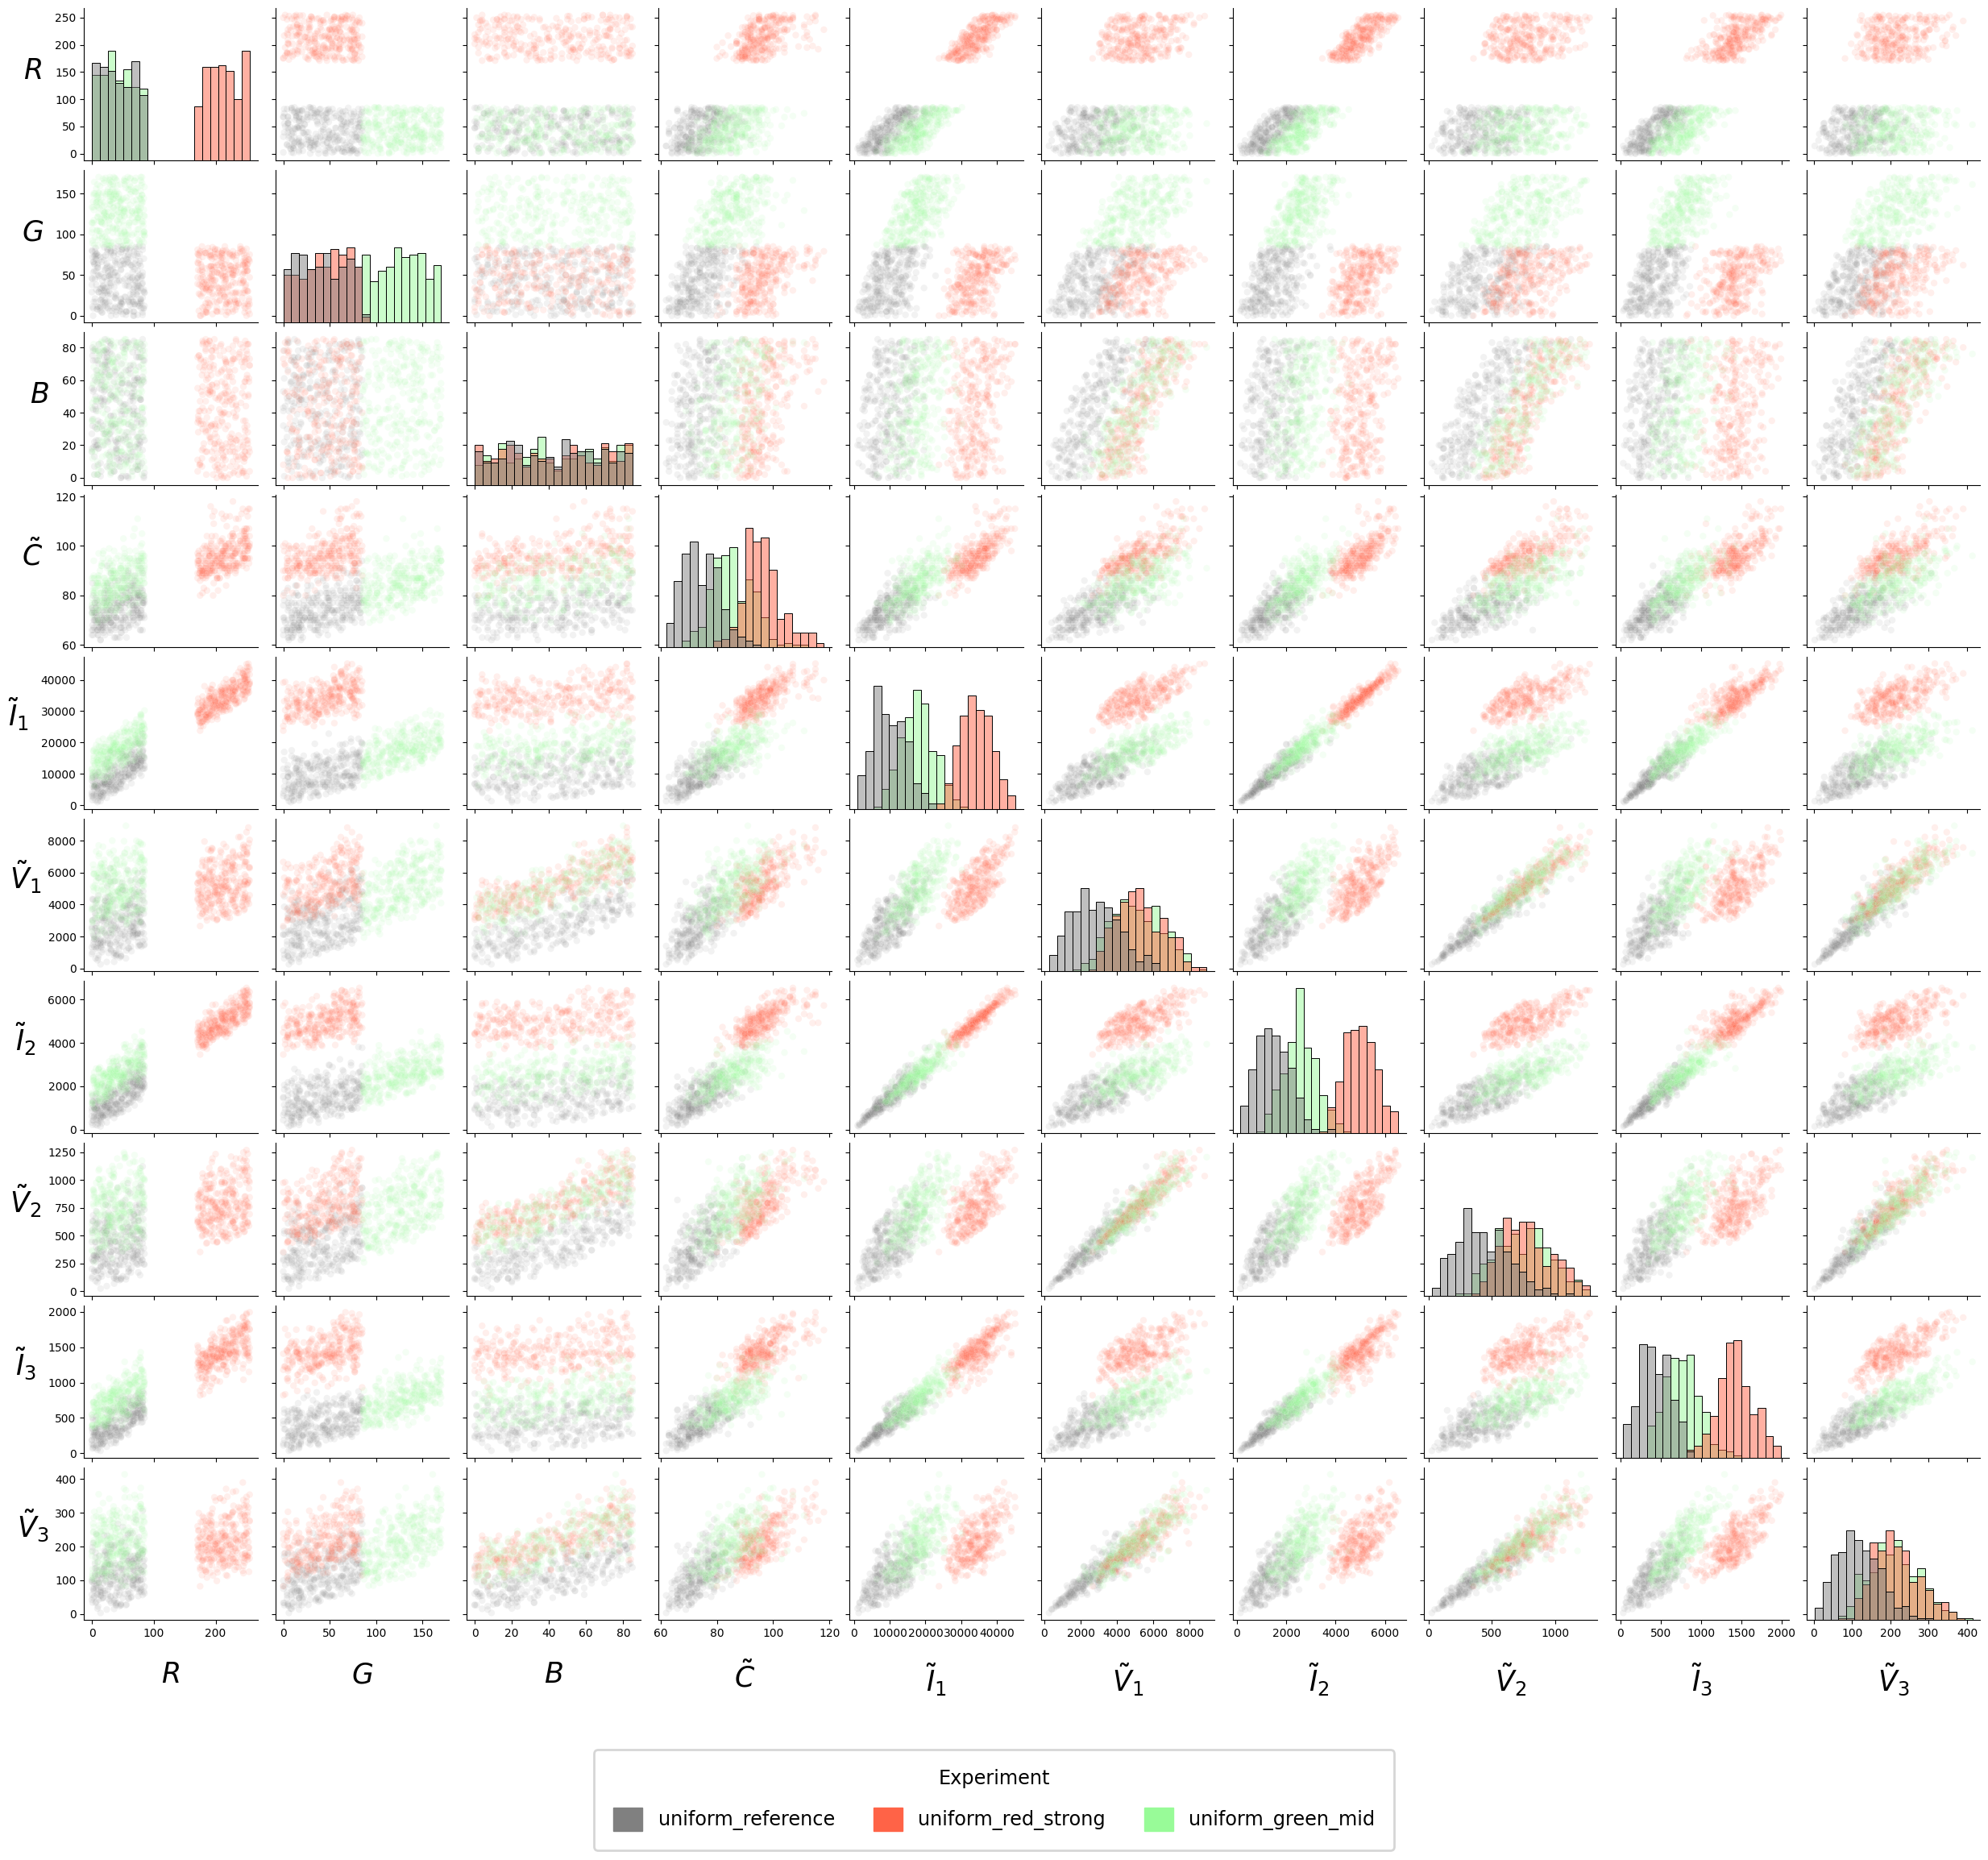

In [83]:
pairplot(experiments=['uniform_reference', 'uniform_red_strong', 'uniform_green_mid'], 
         colors = ['grey', 'tomato', 'palegreen'],
         variables=SMALL_VAR)

#### Results - relationships:

- Either no dependence or linear dependence

#### Results - distribution:

- R,G,B are not Gaussian but Uniform
- Additive noise on top of R,G,B -> Anything looks more unfirom than Gaussian
- Sum of R,G,B closer to Gaussian due to CLT
- If we assume an additive noise model (which most Causal Discovery algorithms or inherent tests do), then the noise contribution is not homoscedastic
- The joint distribution will surely not be jointly Gaussian

#### Implications for causal discovery algorithms:

- PC algorithm with Fisher z conditional independence test
  - assumes joint distribution to be jointly Gaussian

# Marginal Variances